# LSTM
Use sequence from GenCode files.

Acc ~ 50% (killed on Windows after 1 day)
Model = LSTM 64 64, Dense 64 50% drop 16 1. Act=relu. 
Coding 1K-4K. 3fcv-5e. Win. 

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-11-13 10:43:45.564981
Python 3.10.6
sklearn 1.1.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
#from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

EPOCHS=5
FOLDS=3
EMBED_DIMEN=4
MAXLEN=4000   # this is problematic as some genes will be excluded entirely or partially
MINLEN=1000

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows


In [4]:
GENES_FILE = 'CNRCI_coding_train_genes.csv'
RCI_FILE = 'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
#COUNTS_FILE='CNRCI_coding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=0
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Data Load

In [6]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-11-13 10:43:55.804168
Num RCI: 10338
[('ENSG00000000003', 1.08068), ('ENSG00000000419', 1.32679), ('ENSG00000000457', 0.434284)]


In [7]:
# one hot
print(datetime.now())
print('Load sequence')
filepath = DATA_DIR+SEQUENCE_FILE
labels=[]
allids=[]
allseq=[]
NREPEAT = str('N'*MAXLEN)
HOTS = {'A':[1,0,0,0], 'C':[0,1,0,0], 'G':[0,0,1,0], 'T':[0,0,0,1], 'N':[0,0,0,0]}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            tran_id = fields[0]  # with version number
            gene_id = fields[1]        # without version number
            seq_len = int(fields[3])
            seq_txt = fields[4]
            if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                if seq_len<MAXLEN:
                    seq_txt = seq_txt + NREPEAT
                    seq_txt = seq_txt[:MAXLEN]
                seq_chr = list(seq_txt)
                seq_hot = []
                for c in seq_chr:
                    one_hot = HOTS[c]
                    seq_hot.append(one_hot)
                allseq.append(seq_hot)
print(datetime.now())
print('Num IDs:',len(allids))
#print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
#print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
#print('Example:',allseq[3])

2022-11-13 10:43:55.879652
Load sequence
2022-11-13 10:44:09.442296
Num IDs: 25714
Num labels: 25714
Num counts: 25714


In [8]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    subsetX = np.array(subsetX)
    subsetY = np.array(subsetY).reshape((-1,1))
    return subsetX,subsetY

In [9]:
def build_model():
    DIMEN=4  # ONE HOT CATEGORIES
    ACT = 'relu'
    rnn = Sequential()
    embed_layer = Embedding(DIMEN,EMBED_DIMEN,input_length=MAXLEN);
    # rnn1_layer = Bidirectional(
    rnn1_layer = LSTM(64, return_sequences=True, input_shape=[MAXLEN,DIMEN]) 
    rnn2_layer = LSTM(64, return_sequences=True)
    # Dense can handle sequence input. Is it the best thing to do?
    dense1_layer = Dense(64,activation=ACT,dtype=dt)
    dropout1_layer = Dropout(0.50)
    dense2_layer = Dense(16,activation=ACT,dtype=dt)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(rnn2_layer)
    rnn.add(dense1_layer)
    rnn.add(dropout1_layer)
    rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [10]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-11-13 10:44:09.522222
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4000, 64)          17664     
                                                                 
 lstm_1 (LSTM)               (None, 4000, 64)          33024     
                                                                 
 dense (Dense)               (None, 4000, 64)          4160      
                                                                 
 dropout (Dropout)           (None, 4000, 64)          0         
                                                                 
 dense_1 (Dense)             (None, 4000, 16)          1040      
                                                                 
 dense_2 (Dense)             (None, 4000, 1)           17        
                                                                 
Total params: 55,905


In [11]:
SCALING = False
def do_cross_validation(eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        fold += 1
        print('Fold',fold)
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,allseq,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,allseq,labels,0)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        print('Train sizes',X_train.shape,y_train.shape)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
    print()
    return cv_scores
print(datetime.now())

2022-11-13 10:44:10.518964


Issues to address:

Reduce dtype to int8?
Call arguments received by layer "sequential" "                 f"(type Sequential):
inputs=tf.Tensor(shape=(None, 4000, 4), dtype=int32)

The genes were shuffled but the transcripts were not.  
That could retard training.

Loading sequence takes minutes. Save one-hot dataset to binary file. 

Loading sequence takes RAM. A numpy array of one-hot might require less RAM. Write a just-in-time loader.

Accuracy goes down at the start of each epoch. This could mean that the data are not shuffled sufficiently.

2022-11-13 10:44:10.539866
2022-11-13 10:44:10.539866
splitting
Fold 1
Train sizes (17188, 4000, 4) (17188, 1)
Valid sizes (8526, 4000, 4) (8526, 1)
Train set ones/size 8817 / 17188
Valid set ones/size 4176 / 8526
BUILD MODEL
COMPILE
FIT
2022-11-13 10:44:48.217440
Epoch 1/5
538/538 [==============================] - 2782s 5s/step - loss: 0.6705 - accuracy: 0.5902 - val_loss: 0.6647 - val_accuracy: 0.5964
Epoch 2/5
538/538 [==============================] - 2882s 5s/step - loss: 0.6616 - accuracy: 0.6035 - val_loss: 0.6899 - val_accuracy: 0.5289
Epoch 3/5
538/538 [==============================] - 2821s 5s/step - loss: 0.6797 - accuracy: 0.5607 - val_loss: 0.6932 - val_accuracy: 0.4903
Epoch 4/5
538/538 [==============================] - 2818s 5s/step - loss: 0.6932 - accuracy: 0.5117 - val_loss: 0.6937 - val_accuracy: 0.4900
Epoch 5/5
538/538 [==============================] - 2849s 5s/step - loss: 0.6929 - accuracy: 0.5127 - val_loss: 0.6943 - val_accuracy: 0.4899


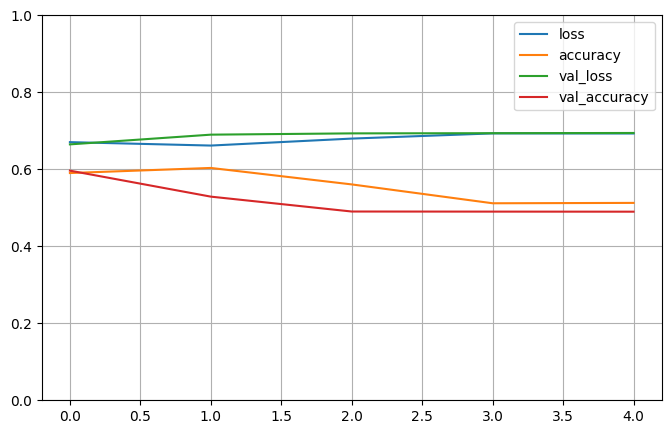

Compute valiation accuracy
2022-11-13 14:40:40.657828
accuracy: 48.99%
2022-11-13 14:44:19.671169
Fold 2
Train sizes (16974, 4000, 4) (16974, 1)
Valid sizes (8740, 4000, 4) (8740, 1)
Train set ones/size 8621 / 16974
Valid set ones/size 4372 / 8740
BUILD MODEL
COMPILE
FIT
2022-11-13 14:45:00.951487
Epoch 1/5
531/531 [==============================] - 2961s 6s/step - loss: 0.6699 - accuracy: 0.5888 - val_loss: 0.6827 - val_accuracy: 0.5433
Epoch 2/5
531/531 [==============================] - 2890s 5s/step - loss: 0.6615 - accuracy: 0.6030 - val_loss: 0.6592 - val_accuracy: 0.6017
Epoch 3/5
531/531 [==============================] - 2861s 5s/step - loss: 0.6801 - accuracy: 0.5459 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 4/5
531/531 [==============================] - 2831s 5s/step - loss: 0.6931 - accuracy: 0.5068 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 5/5
531/531 [==============================] - 2858s 5s/step - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6932 - val_acc

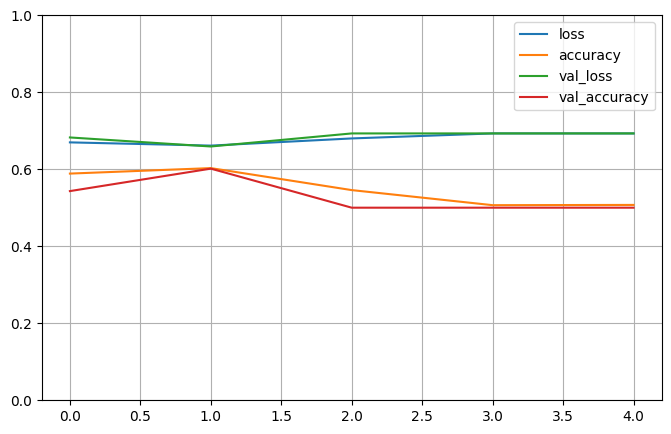

Compute valiation accuracy
2022-11-13 18:45:02.597529
accuracy: 50.02%
2022-11-13 18:48:43.107677
Fold 3
Train sizes (17266, 4000, 4) (17266, 1)
Valid sizes (8448, 4000, 4) (8448, 1)
Train set ones/size 8548 / 17266
Valid set ones/size 4445 / 8448
BUILD MODEL
COMPILE
FIT
2022-11-13 18:49:21.337454
Epoch 1/5
540/540 [==============================] - 2926s 5s/step - loss: 0.6698 - accuracy: 0.5925 - val_loss: 0.6619 - val_accuracy: 0.6313
Epoch 2/5
540/540 [==============================] - 2851s 5s/step - loss: 0.6862 - accuracy: 0.5367 - val_loss: 0.6935 - val_accuracy: 0.4738
Epoch 3/5
270/540 [==============>...............] - ETA: 22:21 - loss: 0.6927 - accuracy: 0.5150

In [ ]:
print(datetime.now())
cv_scores = do_cross_validation(EPOCHS)    
print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
print(datetime.now())